# Sentimentic analysis on Amazon Fine Food Reviews Dataset using NLTK methodology, naive Bayes, Logistic Regression and metrics like roc_curve and auc value, confusion_matrix and and classification_report

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

messages=pd.read_csv(r"C:\Users\paisa\Downloads\Reviews.csv")

messages = messages[['Score', 'Summary']]

In [2]:
messages.dropna(inplace = True)

messages.head()

,Score,Summary
0,5,Good Quality Dog Food
1,1,Not as Advertised
2,4,"""Delight"" says it all"
3,2,Cough Medicine
4,5,Great taffy


Changing the score into positive and negative recommendation with a score < 3 goes in the negative sentiment list and score >= 3 goes in the positive sentiment list.

In [3]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

Score=messages['Score']
Score= Score.map(partition)
Summary=messages['Summary']
X_train, X_test, y_train, y_test = train_test_split(Summary, Score, test_size=0.2, random_state=42)

In [4]:
tmp=messages
tmp['Score']=tmp['Score'].map(partition)
tmp.head()

,Score,Summary
0,positive,Good Quality Dog Food
1,negative,Not as Advertised
2,positive,"""Delight"" says it all"
3,negative,Cough Medicine
4,positive,Great taffy


In [5]:
stemmer=PorterStemmer()
def stem_tokens(token, stemmer):
    stemmed=[]
    for item in token:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [6]:
def tokenize(text):
    token=nltk.word_tokenize(text)
    stems=stem_tokens(token,stemmer)
    return ' '.join(stems)

In [7]:
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

In [8]:
corpus=[]

for text in X_train:
    text=str(text).lower()
    text=text.translate(trantab)
    text=tokenize(text)
    corpus.append(text)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(corpus)        
        
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

Same procedure is applied on the test data.

In [9]:
test_corpus = []

for text in X_test:
    text=str(text).lower()
    text=text.translate(trantab)
    text=tokenize(text)
    test_corpus.append(text)


X_new_counts = count_vect.transform(test_corpus)

X_test_tfidf = tfidf_transformer.transform(X_new_counts)

# The changes before and after all the preprocess and nltk techniques.

In [10]:
df=pd.DataFrame({'Before': X_train, 'After': corpus})
df.head()

,Before,After
321645,soooo goooood. great with ice cream!,soooo goooood great with ice cream
72131,Sweet Sticks are a Winner,sweet stick are a winner
80123,"Graet product, great price",graet product great price
49098,"Quick ship, good quality",quick ship good qualiti
317894,Cherry cough syrup K-cups?,cherri cough syrup k cup


In [11]:
predictors={}
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB().fit(X_train_tfidf, y_train)
predictors['Multinomial']= model.predict(X_test_tfidf)

In [12]:
from sklearn.naive_bayes import BernoulliNB
model=BernoulliNB().fit(X_train_tfidf, y_train)
predictors['Bernoulli']= model.predict(X_test_tfidf)

In [13]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e6)
logreg.fit(X_train_tfidf, y_train)
predictors['Logistic'] = logreg.predict(X_test_tfidf)

C:\Users\paisa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


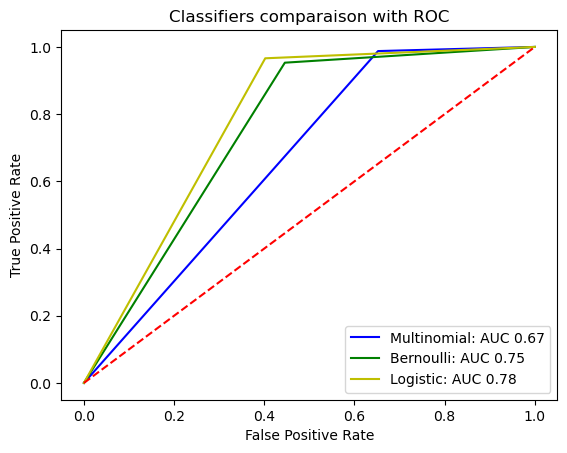

In [14]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in predictors.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Understanding the model result with classification_report and confusion_matrix

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
print(classification_report(y_test, predictors['Logistic']))

              precision    recall  f1-score   support

    negative       0.75      0.60      0.66     16301
    positive       0.93      0.97      0.95     97385

    accuracy                           0.91    113686
   macro avg       0.84      0.78      0.81    113686
weighted avg       0.91      0.91      0.91    113686



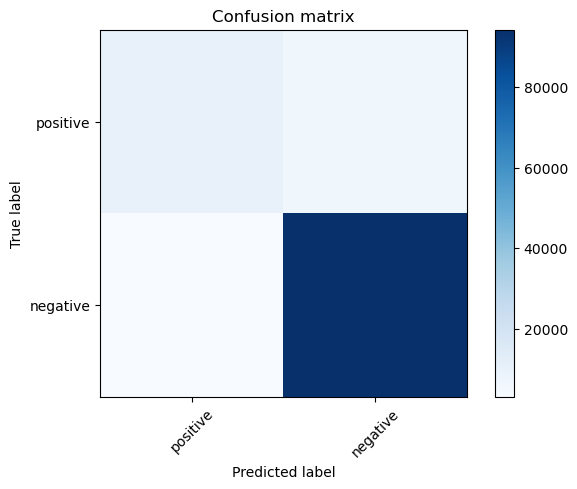

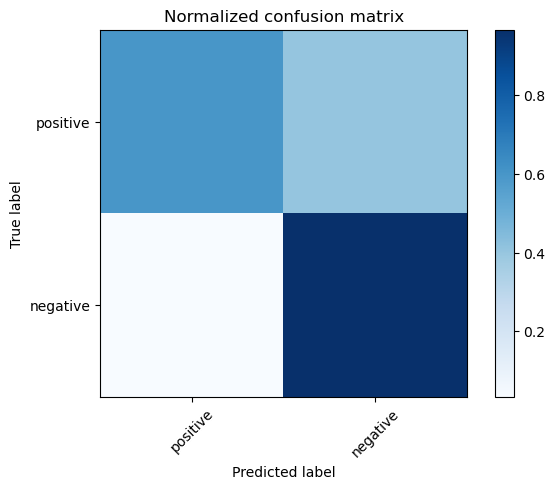

In [17]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(Score)))
    plt.xticks(tick_marks, set(Score), rotation=45)
    plt.yticks(tick_marks, set(Score))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, predictors['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()